In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/superstore/Global Superstore Orders 2016.xlsx


This is a dataset of orders placed for an international superstore. The aim of this notebook is to show a real world use case, showing how to frame the churn problem, analyse the dataset,create a model, and then test/validate it, as well as looking at what the end-benefit is to the business.

**1. Define the problem**

The customers we are considering for this problem are 'regular customers' since a customer who only purchases once, has not churned, they are simply not a regulat customer to begin with. A customer is considered to have 'churned' if they are a repeat customer, and have not placed a new order within x number of days. To determine the number x, we load the data set, clean as necessary, and analyse the distribution of days between orders

In [2]:
#import relevant libraries and read in data
!pip install openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 KB 516.6 kB/s eta 0:00:00


In [3]:
l = pd.DataFrame(data={'customer': ['A','A','B','C','C','C'], 'date': [1,1,2,3,3,4], 'product': ['a','b','c','d','e','f'], 'price': [10,11,12,13,14,15]})
r = pd.DataFrame(data={'customer': ['C', 'C'], 'date': [3, 4],'churn': [0, 1]})
l

,customer,date,product,price
0,A,1,a,10
1,A,1,b,11
2,B,2,c,12
3,C,3,d,13
4,C,3,e,14
5,C,4,f,15


In [4]:
r

,customer,date,churn
0,C,3,0
1,C,4,1


In [5]:
new = pd.merge(l,r,how = 'left', on = ['customer', 'date'])
new

,customer,date,product,price,churn
0,A,1,a,10,NaN
1,A,1,b,11,NaN
2,B,2,c,12,NaN
3,C,3,d,13,0.0
4,C,3,e,14,0.0
5,C,4,f,15,1.0


In [6]:
new = pd.merge(l,r,how = 'right', on = ['customer', 'date'])
new

,customer,date,product,price,churn
0,C,3,d,13,0
1,C,3,e,14,0
2,C,4,f,15,1


In [7]:
df = pd.read_excel('../input/superstore/Global Superstore Orders 2016.xlsx')
pd.set_option('display.max_columns', None)
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%Y-%m-%d')
df = df.sort_values(by = 'Order Date')
df.head()
#the Postal Code column has multiple NaN values, so I'm just going to drop it
df = df.drop('Postal Code', axis = 1)
df

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Region,Market,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
22950,22253,IN-2012-JH159857-40909,2012-01-01,2012-01-08,Standard Class,JH-159857,Joseph Holt,Consumer,Wagga Wagga,New South Wales,Australia,Oceania,Asia Pacific,OFF-SU-3002,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.366,3,0.10,36.0360,9.720,Medium
43610,22254,IN-2012-JH159857-40909,2012-01-01,2012-01-08,Standard Class,JH-159857,Joseph Holt,Consumer,Wagga Wagga,New South Wales,Australia,Oceania,Asia Pacific,OFF-PA-3990,Office Supplies,Paper,"Eaton Computer Printout Paper, 8.5 x 11",55.242,2,0.10,15.3420,1.800,Medium
25078,48883,HU-2012-AT73557-40909,2012-01-01,2012-01-05,Second Class,AT-73557,Annie Thurman,Consumer,Budapest,Budapest,Hungary,Eastern Europe,Europe,OFF-ST-6230,Office Supplies,Storage,"Tenex Box, Single Width",66.120,4,0.00,29.6400,8.170,High
31870,22255,IN-2012-JH159857-40909,2012-01-01,2012-01-08,Standard Class,JH-159857,Joseph Holt,Consumer,Wagga Wagga,New South Wales,Australia,Oceania,Asia Pacific,FUR-FU-4075,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",113.670,5,0.10,37.7700,4.700,Medium
31583,11731,IT-2012-EM14140124-40909,2012-01-01,2012-01-05,Second Class,EM-14140124,Eugene Moren,Home Office,Stockholm,Stockholm,Sweden,Northern Europe,Europe,OFF-PA-4177,Office Supplies,Paper,"Enermax Note Cards, Premium",44.865,3,0.50,-26.0550,4.820,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17379,10625,ES-2015-ES1402048-42369,2015-12-31,2016-01-04,Standard Class,ES-1402048,Erica Smith,Consumer,Bielefeld,North Rhine-Westphalia,Germany,Western Europe,Europe,OFF-SU-4991,Office Supplies,Supplies,"Kleencut Shears, Serrated",260.820,6,0.00,12.9600,15.790,High
42870,32203,CA-2015-PO18865140-42369,2015-12-31,2016-01-04,Standard Class,PO-188651406,Patrick O'Donnell,Consumer,New York City,New York,United States,Eastern US,USCA,FUR-BO-3651,Furniture,Bookcases,"Bush Westfield Collection Bookcases, Fully Ass...",323.136,4,0.20,12.1176,38.270,High
39873,5029,MX-2015-SC2026082-42369,2015-12-31,2016-01-02,Second Class,SC-2026082,Scott Cohen,Corporate,Durango,Durango,Mexico,Central America,LATAM,OFF-LA-3310,Office Supplies,Labels,"Avery Removable Labels, 5000 Label Set",22.260,3,0.00,3.9600,2.274,High
7908,28570,ID-2015-MY18295102-42369,2015-12-31,2016-01-04,Standard Class,MY-18295102,Muhammed Yedwab,Corporate,Manila,National Capital,Philippines,Southeastern Asia,Asia Pacific,TEC-CO-4570,Technology,Copiers,"Hewlett Copy Machine, Laser",684.606,4,0.35,-63.2340,42.920,Medium


In [8]:
df_grouped = df.groupby('Customer ID')['Order Date'].apply(lambda x: x.diff().mean()).dt.days.to_frame('Avg_Difference')
df_grouped.head(20)

,Avg_Difference
Customer ID,
AA-10315102,183.0
AA-10315120,NaN
AA-10315139,26.0
AA-103151402,96.0
AA-103151404,276.0
AA-103151406,0.0
AA-1031545,NaN
AA-1031548,NaN
AA-1031558,357.0


The 40th Percentile for the number of days between purchases is: 114.0


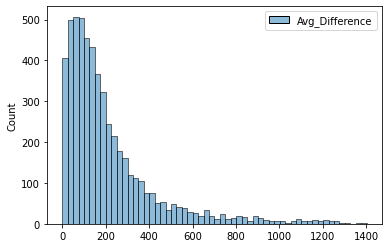

In [9]:
#we can see that some people bought only one item [ie NaN] and some bought multiple items, but only on one date[ie 0]
#these are not regular customers, so we can exclude them from the dataset for the purpose of our analysis
df_grouped = df_grouped.dropna()
df_grouped = df_grouped.loc[df_grouped['Avg_Difference'] != 0]
#now we plot a histogram
sns.histplot(data = df_grouped, binwidth = 25)
# This shows a very right skewed distribution. As such, a high percentile is not a gd measure of churn
# as the business in general has more sporadic than regular customers.
print("The 40th Percentile for the number of days between purchases is: " + str(df_grouped['Avg_Difference'].quantile(0.4)))


So completing our statement above:

**1. Define the problem**

A customer is considered to have 'churned' if they are a repeat customer, and have not placed a new order within 114 days.

The above analysis is enought to classify a customer based on whether they have churned or not. I cannot show this on the current dataset as it is a past CSV, but for an active business, it would be the case of querying a Database for customers who have not placed orders in the last 114 days.

From a busniess use case perspective, this might be all that you want to know. This could be used to now send emails out to the churned customers, which might for example say, 'We haven't heard from you in a while, we just wanted to let you know we're operating as usual, and we'd love to have you back'. They could also include offers/incentives to try to regain those customers. 

But what if you wanted to try to predict this ahead of time? This is a more proactive approach - try to indentiy those customers who are likely to churn, and take steps to ensure we retain them as customers. For this, we need a model




**2. Define the model**

**a) what are the inputs?**

Using the Dataframe, we can see that potential explanatory variables, effecting whether a customer will churn, might include: Ship Mode, Segment, City, State, Country, Region, Market, Category, Sub-Category, Quantity, Discount, Shipping Cost, Order Priority. It is worth noting that, in a real business case, we would usually have a Relational Database which we could query to get more useful information about the customers/customer profile. With the limited dependent variable data that we have, the model is unilkely to be very accurate. But for the purposes of demonstration, it will suffice.

**b) what are the outputs?**

A simple and effective approach is to turn this into a classification problem. An example might be, to set a time period, eg 30 days, and say,"Will this customer churn in the next 30 days?" Being able to predict this, will give us a chance, to contact them, target offers etc in order to retain them *before* they churn. In order to carry this out, we need to go over the Dataframe, and make a new column which includes whether the customer will churn in the next 30 days, based on our definition above. We will then run a model to use for prediction. There are various models to chose from, and ideally you would test multiple models, for for simplicity, I will use just Random Forest.

In [10]:
#Create a Churn column, define a unqiue dataframe view for each customer, removing duplicates for multiple orders on the same date
# For each order, determine if there is another order in the next 114 days
# During writing the code, it became clear that NaN/NaT values [for when there is no new order] returned a False value
#This is not the whole story. Since this is a historic dataset, we don't know after the last order, if the next one was placed
# within our 114 day period or not. df.tail() shows us that 2015-12-31 is the last date recorded on the data set
# We could write conditional logic for this dataset to address the above problem, but given the flaws this can introduce, dropping
# this value is the more straightforward approach. So we make a dataframe for each customer, remove duplicate lines for the same order
# add in the logic for if they churn, do a join to our original dataframe to get the info from the other columns, then 
# keep appending this new dataframe until the loop ends
newdf = pd.DataFrame(columns = ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'City', 'State', 'Country',
       'Region', 'Market', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit',
       'Shipping Cost', 'Order Priority', 'Churn'])

for c in df_grouped.index:
    tempdf = df.loc[df['Customer ID'] == c]
    tempdf = tempdf[['Customer ID', 'Order Date']]
    tempdf['Churn'] = np.nan
    tempdf = tempdf.drop_duplicates()
    tempdf['Churn'] = pd.to_numeric((tempdf['Order Date'].shift(-1) - tempdf['Order Date']).dt.days)
    tempdf = tempdf.dropna()
    tempdf['Churn'] = tempdf['Churn'] >=114
    tempdf = pd.merge(df.loc[df['Customer ID'] == c], tempdf, how = 'left', on = ['Customer ID','Order Date'])
    tempdf = tempdf.dropna()
    newdf = pd.concat([newdf, tempdf], ignore_index=True)

newdf

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Region,Market,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,Churn
0,27385,ID-2012-AA10315102-41093,2012-07-03,2012-07-06,First Class,AA-10315102,Alex Avila,Consumer,Marikina,National Capital,Philippines,Southeastern Asia,Asia Pacific,OFF-LA-3322,Office Supplies,Labels,"Avery Shipping Labels, Alphabetical",44.9295,7,0.45,-4.2105,6.91,High,True
1,27387,ID-2012-AA10315102-41093,2012-07-03,2012-07-06,First Class,AA-10315102,Alex Avila,Consumer,Marikina,National Capital,Philippines,Southeastern Asia,Asia Pacific,OFF-SU-4327,Office Supplies,Supplies,"Fiskars Trimmer, Serrated",278.8500,13,0.45,-141.9600,30.01,High,True
2,27386,ID-2012-AA10315102-41093,2012-07-03,2012-07-06,First Class,AA-10315102,Alex Avila,Consumer,Marikina,National Capital,Philippines,Southeastern Asia,Asia Pacific,TEC-AC-5889,Technology,Accessories,"SanDisk Numeric Keypad, USB",29.2380,1,0.45,-8.5320,6.66,High,True
3,27384,ID-2012-AA10315102-41093,2012-07-03,2012-07-06,First Class,AA-10315102,Alex Avila,Consumer,Marikina,National Capital,Philippines,Southeastern Asia,Asia Pacific,OFF-SU-4132,Office Supplies,Supplies,"Elite Shears, High Speed",51.7110,2,0.45,-23.5290,1.77,High,True
4,19020,ES-2014-AA10315139-41901,2014-09-19,2014-09-21,Second Class,AA-10315139,Alex Avila,Consumer,Nottingham,England,United Kingdom,Northern Europe,Europe,TEC-PH-5254,Technology,Phones,"Motorola Headset, with Caller ID",159.4800,2,0.00,52.6200,51.79,Critical,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16617,18446,IT-2013-ZD2192545-41468,2013-07-13,2013-07-17,Standard Class,ZD-2192545,Zuschuss Donatelli,Consumer,Marignane,Provence-Alpes-Côte d'Azur,France,Western Europe,Europe,TEC-CO-4578,Technology,Copiers,"Hewlett Fax Machine, Laser",815.7960,3,0.15,-95.9940,85.36,High,True
16618,12386,ES-2012-ZD2192548-41234,2012-11-21,2012-11-23,Second Class,ZD-2192548,Zuschuss Donatelli,Consumer,Bremen,Bremen,Germany,Western Europe,Europe,OFF-LA-3311,Office Supplies,Labels,"Avery Removable Labels, Adjustable",43.2000,5,0.00,19.8000,10.44,High,True
16619,12387,ES-2012-ZD2192548-41234,2012-11-21,2012-11-23,Second Class,ZD-2192548,Zuschuss Donatelli,Consumer,Bremen,Bremen,Germany,Western Europe,Europe,TEC-MA-4999,Technology,Machines,"Konica Calculator, Red",97.5600,2,0.00,38.0400,11.72,High,True
16620,11670,IT-2013-ZD2192548-41503,2013-08-17,2013-08-22,Standard Class,ZD-2192548,Zuschuss Donatelli,Consumer,Berlin,Berlin,Germany,Western Europe,Europe,FUR-CH-5441,Furniture,Chairs,"Office Star Executive Leather Armchair, Adjust...",1127.8080,3,0.20,-126.8820,72.71,Medium,True


In [11]:
#Create the model
df = newdf
#one hot encode the nominal catagorical columns
categorical_columns = ['Segment', 'City', 'State', 'Country', 'Region', 'Market', 'Category', 'Sub-Category',]
for column in categorical_columns:
    tempdf = pd.get_dummies(df[column], prefix=column)
    df = pd.merge(
        left=df,
        right=tempdf,
        left_index=True,
        right_index=True,
    )
    df = df.drop(columns=column)

#Ordinal encoding Ordinal Catagories with map
df['Order Priority'].unique()
#Displays values Critical, Medium, High, Low, 
df['Ship Mode'].unique()
#Displays values Standard Class', 'Second Class', 'Same Day', 'First Class'

#rather than sklearns encoder, the map method is easier. We have to map to a string first, then convert it to an int afterwards
df['Order Priority'] = df['Order Priority'].map({'Critical': '1', 'Medium': '2', 'High': '3', 'Low': '4'}).astype(int)
df['Ship Mode'] = df['Ship Mode'].map({'Second Class':'4','Standard Class':'3', 'First Class':'2', 'Same Day':'1'}).astype(int)

In [12]:
#Split dependant and independant variables, and remove columns which don't matter   
x = df.drop(['Churn','Row ID', 'Order ID', 'Order Date', 'Ship Date','Product ID','Product Name','Customer ID', 'Customer Name'], axis = 1)
y = df['Churn']
#the y column is of dtype object for some reason! So we change it to an integer so sklearn can recognise it properly
y = y.astype(int)

In [13]:
#Split test and train data
xtrain, xtest, ytrain, ytest = train_test_split(
		x, y, test_size = 0.25, random_state = 0)

#Scale data and make non numeric data numeric
sc_x = StandardScaler()
xtrain = sc_x.fit_transform(xtrain)
xtest = sc_x.transform(xtest)



In [14]:

#Find best parameters for classifier
my_dict = {}
for n in range(10,210,10):
    mean = cross_val_score(RandomForestClassifier(n_estimators = n), xtrain, ytrain).mean()
    my_dict[n] = mean
print(my_dict)


#There's no need to place in a series and order the data, a quick looks shows us the best accuracy comes with an n_estimator of 100

{10: 0.777393831839013, 20: 0.7960852053753718, 30: 0.7924749362368602, 40: 0.7952829269187085, 50: 0.7977697295812397, 60: 0.7987321034582475, 70: 0.7967267450706406, 80: 0.798010339134018, 90: 0.7964864571883874, 100: 0.7964861998519672, 110: 0.7973686386034867, 120: 0.7968872586626677, 130: 0.7976092481562649, 140: 0.7987322321264576, 150: 0.7972885748097881, 160: 0.7994541251188975, 170: 0.7977696652471347, 180: 0.798010467802228, 190: 0.7985719115367454, 200: 0.797288188805158}


In [15]:
#Train and test the model
#train logistic regression model
clf = RandomForestClassifier(n_estimators = 100, random_state = 0)
clf.fit(xtrain, ytrain)
#Predict a value
y_pred = clf.predict(xtest)
#Confusion matrix
cm = confusion_matrix(ytest, y_pred)
acc = accuracy_score(ytest, y_pred)
print ("Confusion Matrix : \n", cm)
print ("Accuracy Score : \n", acc)

Confusion Matrix : 
 [[ 168  773]
 [  85 3130]]
Accuracy Score : 
 0.7935514918190568


**3. Evaluation of the Model**

We have used the model with some very limited features, on a slightly unbalanced dataset. The accuracy score of the model is 79% on the test data, which is not bad for such limited features!!!


**4. Reflection**

In the real world, we would further optimise our model, deploy it, and then monitor it/look to improve it as it is being actively used, perhaps at the start of every month. Instead I have chosen to add some important reflective points for this project.

a) The purpose of this project was only to demonstrate Churn analysis. In reality, I would spend more time on examining the data, and cleaning it

b) In reality, we have used a fairly poor test case. The truth is, Kaggle does have some cases like credit cards and Bank customers, but I wanted to use a dataset which has been fairly neglected. It is clear from this business, that there are only a small subset of loyal customers. Many are not repeat customers. Churn analysis is perhaps not ideally suited to the way this business is being run, however if customer loyalty and retention were new objectives the business was looking to pursue, this would be a powerful analytical tool

c) As mentioned previously, the model we created is not going to be good, simply because we don't have enough useful relevant explanatory variables. In a real setting, we could potentially use some SQL queries to generate further information about our customers and add this into our model. We could also use Feature Engineering to add new variables, for eg. 'Number of days since last order', 'Number of items ordered at a time' etc. This may have improved our performance

d) In a full use case, we would use our judgement/expereince to evaluate possible models for suitability, narrow down a small number, and test them all out. We would also cross validate a much larger range of parameters for each model, rather than just n_estimators. In this case however, it simply wasn't worth it

e) The focus in this instance, was arguably more on stopping customers who might churn from doing so, rather than identifying happy, non-churning customers. If this is the case, then the focus would be on the true positive rate. Recall, or a metric incoporating recall such as F1 or F1 Beta may be more appropriate, depending on the business' own objectives